# Capstone Project

This notebook will be used for the capstone project.

## <b> <font color="red"> PART I. SCRAPPING </font></b>

In [41]:
import pandas as pd
import numpy as np

In [42]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


In [43]:
# Initial dataframe with the postal codes

url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
pc = pd.read_html(url)

pc_df = pc[0]

pc_df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [44]:
# Drop rows with Borough not assigned
pc_df.drop( pc_df[ pc_df['Borough'] == 'Not assigned' ].index,inplace=True)
pc_df.reset_index()
pc_df.head()

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [45]:
# if the neighborhood is not assigned, we set its value equal to the district
for index, row in pc_df.iterrows():
    if row['Neighbourhood'] == 'Not assigned':
         pc_df.at[index, "Neighbourhood"] = row['Borough']
pc_df.head()

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Rename the last column:

In [46]:
pc_df.rename(columns={'Neighbourhood': 'Neighborhood'},inplace=True)
pc_df.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [47]:
pc_df.shape

(103, 3)

## <b> <font color="red"> PART II. GEOESPACIAL DATA </font></b>

In [48]:
import urllib.request
url = 'http://cocl.us/Geospatial_data'
filename = 'Geospatial_data.csv'
urllib.request.urlretrieve(url, filename)

# Geospatial data dataframe
gs_df = pd.read_csv(filename)

gs_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [49]:
# merge the dataframes by Postal Code (inner join)
final_df = pd.merge(left=pc_df,right=gs_df, left_on='Postal Code', right_on='Postal Code')
final_df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [50]:
final_df.shape

(103, 5)

## <b> <font color="red"> PART III. ANALYSIS </font></b>

## 1. Explore Dataset

In [51]:
# remove districts that do not contain the word Toronto
toronto_data = final_df[final_df['Borough'].str.contains('Toronto', regex=False)].reset_index(drop=True)
toronto_data.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [52]:
toronto_data.shape

(39, 5)

Libraries needed

In [53]:
import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

geographic coordinates of Toronto

In [54]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


Neighbourhoods in Toronto

In [55]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Credentials and version for the Foursquare API.

In [99]:
CLIENT_ID = '*****************' # your Foursquare ID
CLIENT_SECRET = '*****************' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

## 2. Explore Neighborhoods in Toronto

In [57]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Create a new dataframe with the venue data

In [58]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

In [59]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


Size of the new dataframe

In [60]:
toronto_venues.shape

(1608, 7)

How many venues were returned for each neighborhood:

In [61]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,56,56,56,56,56,56
"Brockton, Parkdale Village, Exhibition Place",22,22,22,22,22,22
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,62,62,62,62,62,62
Christie,16,16,16,16,16,16
Church and Wellesley,79,79,79,79,79,79
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,36,36,36,36,36,36


How many unique categories can be curated from all the returned venues

In [62]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 235 uniques categories.


## 3. Analyze Each Neighborhood

In [63]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Size of the dataframe

In [64]:
toronto_onehot.shape

(1608, 235)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [65]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,Berczy Park,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.00,0.017857,0.00000,0.000000,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.00000,0.000000,0.000000
2,"Business reply mail Processing Centre, South C...",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.00000,0.000000,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.000000,0.0625,0.0625,0.0625,0.125,0.125,0.125,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.00000,0.000000,0.000000
4,Central Bay Street,0.016129,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.00,0.016129,0.00000,0.000000,0.016129
5,Christie,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.00000,0.000000,0.000000
6,Church and Wellesley,0.025316,0.012658,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.012658,...,0.012658,0.012658,0.00000,0.000000,0.00000,0.00,0.000000,0.00000,0.000000,0.000000
7,"Commerce Court, Victoria Hotel",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.040000,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.00,0.020000,0.00000,0.000000,0.010000
8,Davisville,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,...,0.000000,0.000000,0.00000,0.027778,0.00000,0.00,0.000000,0.00000,0.000000,0.000000
9,Davisville North,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.00000,0.000000,0.000000


In [66]:
toronto_grouped.shape

(39, 235)

New dataframe selecting only the relevant characteristics

In [67]:
gym_df = toronto_grouped[['Neighborhood','Gym']]
gym_df.head()

,Neighborhood,Gym
0,Berczy Park,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.045455
2,"Business reply mail Processing Centre, South C...",0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000
4,Central Bay Street,0.000000


## 4. Cluster Neighborhoods

K-Means clustering

Let's start by finding the best value of k. We will use the elbow method.

In [68]:
gym_df_clustering = gym_df.drop('Neighborhood', 1)

In [69]:
#!conda install -c districtdatalabs yellowbrick

In [70]:
#!pip install yellowbrick

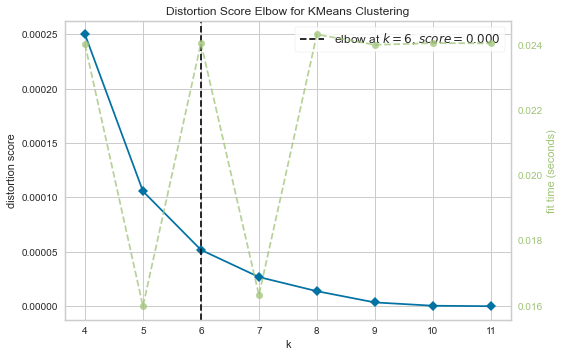

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [71]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

# Generate synthetic dataset with 8 random clusters
X = gym_df_clustering

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


From the graph above we see that the best value is **k = 6**

In [72]:
# number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(gym_df_clustering)

# labels
kmeans.labels_[0:10] 

array([0, 2, 0, 0, 0, 0, 0, 2, 5, 0])

In [73]:
# insert the labels
gym_df.insert(0, 'Cluster Labels', kmeans.labels_) 

add latitud and longitude

In [74]:
final_gym_df = pd.merge(left=final_df,right=gym_df, left_on='Neighborhood', right_on='Neighborhood')
final_gym_df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Gym
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,0.000000
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1,0.027778
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,3,0.010000
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,4,0.025316
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,0.000000


Visualize the clusters

In [75]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))


rainbow = [colors.rgb2hex(i) for i in colors_array] #


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(final_gym_df['Latitude'], final_gym_df['Longitude'], final_gym_df['Neighborhood'], final_gym_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

In [76]:
final_gym_df.loc[final_gym_df['Cluster Labels'] == 0]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Gym
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,0.0
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,0.0
5,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,0,0.0
6,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,0,0.0
7,M6G,Downtown Toronto,Christie,43.669542,-79.422564,0,0.0
9,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259,0,0.0
10,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,0,0.0
11,M6J,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,0,0.0
12,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,0.0
17,M4M,East Toronto,Studio District,43.659526,-79.340923,0,0.0


In [77]:
final_gym_df.loc[final_gym_df['Cluster Labels'] == 1]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Gym
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1,0.027778
8,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,1,0.031250
28,M6S,West Toronto,"Runnymede, Swansea",43.651571,-79.484450,1,0.030303


In [78]:
final_gym_df.loc[final_gym_df['Cluster Labels'] == 2]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Gym
14,M6K,West Toronto,"Brockton, Parkdale Village, Exhibition Place",43.636847,-79.428191,2,0.045455
16,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,2,0.040000
36,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,2,0.040000


In [79]:
final_gym_df.loc[final_gym_df['Cluster Labels'] == 3]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Gym
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,3,0.01
13,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,3,0.01


In [80]:
final_gym_df.loc[final_gym_df['Cluster Labels'] == 4]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Gym
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,4,0.025316
34,M5W,Downtown Toronto,Stn A PO Boxes,43.646435,-79.374846,4,0.020833


In [81]:
final_gym_df.loc[final_gym_df['Cluster Labels'] == 5]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Gym
15,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,5,0.050000
26,M4S,Central Toronto,Davisville,43.704324,-79.388790,5,0.055556


### Visualization

Number of elements per cluster and average of gyms per cluster

In [82]:
%matplotlib inline
import matplotlib.pyplot as plot

listaMedias = []
listaCantidades = []
for n in range(0,6):
    listaMedias.append(final_gym_df.loc[final_gym_df['Cluster Labels'] == n]['Gym'].mean())
    listaCantidades.append(len(final_gym_df.loc[final_gym_df['Cluster Labels'] == n].index))

print(listaMedias)
print(listaCantidades)




[0.0, 0.029776936026936027, 0.04181818181818182, 0.01, 0.02307489451476793, 0.05277777777777778]
[27, 3, 3, 2, 2, 2]


Plot the average number of gyms per cluster

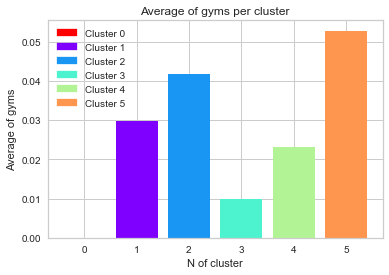

In [97]:
%matplotlib inline
import matplotlib.pyplot as plt


x = [0,1,2,3,4,5]

color = ['#ff0000', '#8000ff', '#1996f3', '#4df3ce', '#b2f396', '#ff964f' ]


plt.bar(x,listaMedias,color=color)

plot.title('Average of gyms per cluster')
plot.xlabel('N of cluster')
plot.ylabel('Average of gyms')


colors = {'Cluster 0':'red', 'Cluster 1':'#8000ff', 'Cluster 2':'#1996f3','Cluster 3':'#4df3ce',
         'Cluster 4':'#b2f396','Cluster 5':'#ff964f'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)



plot.show()

Plot the number of elements per cluster

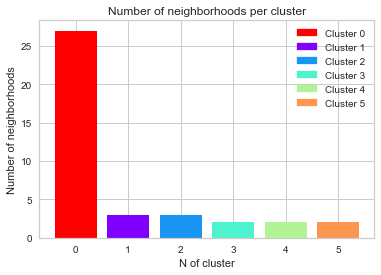

In [98]:
x = [0,1,2,3,4,5]

color = ['#ff0000', '#8000ff', '#1996f3', '#4df3ce', '#b2f396', '#ff964f']

plt.bar(x,listaCantidades,color=color)

plot.title('Number of neighborhoods per cluster')
plot.xlabel('N of cluster')
plot.ylabel('Number of neighborhoods')

colors = {'Cluster 0':'red', 'Cluster 1':'#8000ff', 'Cluster 2':'#1996f3','Cluster 3':'#4df3ce',
         'Cluster 4':'#b2f396','Cluster 5':'#ff964f'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plot.show()